## 网络层

- 全连接层与常见激活函数，供分类与自编码器复用。


In [7]:
import numpy as np


class LinearLayer:
    """全连接层: Y = XW + b"""

    def __init__(self, input_size, output_size):
        # He Initialization (适合 ReLU)
        self.W = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)
        self.b = np.zeros((1, output_size))
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b

    def backward(self, d_out):
        self.dW = np.dot(self.x.T, d_out)
        self.db = np.sum(d_out, axis=0, keepdims=True)
        d_x = np.dot(d_out, self.W.T)
        return d_x


class ReLU:
    """激活函数 ReLU"""

    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, d_out):
        d_x = d_out.copy()
        d_x[self.x <= 0] = 0
        return d_x


class Sigmoid:
    """Sigmoid 激活函数"""

    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, d_out):
        return d_out * self.out * (1 - self.out)



## 损失函数

- Softmax+交叉熵用于分类；MSE 用于自编码器重建误差。


In [8]:
class CrossEntropyWithSoftmax:
    """
    组合 Softmax 和 交叉熵损失。
    输入 logits (线性层的输出)，内部计算概率和 Loss。
    """

    def forward(self, logits, y_onehot):
        self.y_onehot = y_onehot
        self.batch_size = logits.shape[0]

        # 1. Softmax (数值稳定版)
        shift_logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_vals = np.exp(shift_logits)
        self.probs = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

        # 2. Cross Entropy Loss
        loss = -np.sum(y_onehot * np.log(self.probs + 1e-9)) / self.batch_size
        return loss

    def backward(self):
        """
        返回梯度 dL/dZ = (P - Y) / N
        """

        return (self.probs - self.y_onehot) / self.batch_size


def mse_loss(y_pred, y_true):
    """均方误差"""
    return np.mean((y_pred - y_true) ** 2)



## 优化器

- 简单 SGD，对线性层参数做梯度更新。


In [9]:
def step_gradient_sgd(layers, learning_rate):
    """简单的随机梯度下降"""
    for layer in layers:
        if isinstance(layer, LinearLayer):
            layer.W -= learning_rate * layer.dW
            layer.b -= learning_rate * layer.db



## 工具函数

- One-hot、指标计算、mini-batch 生成器。


In [10]:
def to_one_hot(y, num_classes):
    """转 One-hot 编码"""
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    one_hot[np.arange(m), y] = 1
    return one_hot


def calculate_metrics(y_pred_probs, y_true):
    """计算 Accuracy 和 Macro-F1"""
    y_pred = np.argmax(y_pred_probs, axis=1)
    acc = np.mean(y_pred == y_true)

    classes = np.unique(y_true)
    f1_scores = []
    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
        f1_scores.append(f1)

    macro_f1 = np.mean(f1_scores)
    return acc, macro_f1


def get_batches(X, y, batch_size):
    """Mini-batch 生成器 (包含 shuffle)"""
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_idx = indices[start_idx:end_idx]

        yield X[batch_idx], y[batch_idx]



## 训练与演示

- 在同一环境直接运行，无需模块导入。
- 执行前可根据机器性能调小 epoch 或 batch_size。


训练集: (1257, 64), 测试集: (540, 64)
特征维度: 64, 类别数: 10


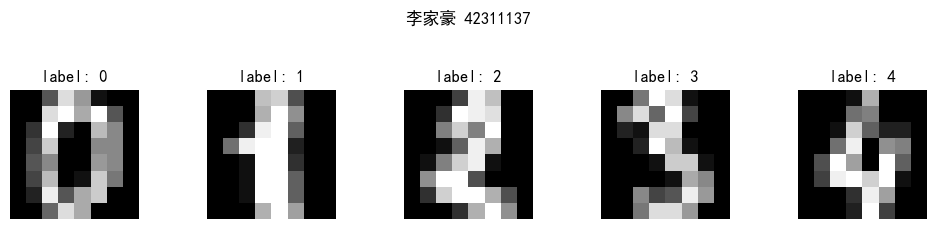

In [11]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取并预处理数据（归一化 + 划分），并做部分样本展示

# 1) 加载数据并归一化到 [0, 1]
digits = load_digits()
X_raw = digits.data
y_raw = digits.target
X = X_raw / 16.0

# 2) 划分数据集（保持类别比例）
X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.3, random_state=42, stratify=y_raw
)

num_classes = 10
input_dim = X.shape[1]
y_test_oh = to_one_hot(y_test, num_classes)

print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")
print(f"特征维度: {input_dim}, 类别数: {num_classes}")

# 3) 可视化前 5 个样本
grid = min(5, len(X_raw))
fig, axes = plt.subplots(1, grid, figsize=(10, 2))
for ax, img, label in zip(axes, X_raw[:grid], y_raw[:grid]):
    ax.imshow(img.reshape(8, 8), cmap="gray")
    ax.set_title(f"label: {label}")
    ax.axis("off")
fig.suptitle("李家豪 42311137", fontsize=12, y=1.12)
plt.tight_layout()
plt.show()




>>> 开始任务 1: BP 神经网络分类
Epoch 0 | Loss: 1.8385 | Test ACC: 0.7630
Epoch 10 | Loss: 0.1656 | Test ACC: 0.9500
Epoch 20 | Loss: 0.0989 | Test ACC: 0.9630
Epoch 30 | Loss: 0.0698 | Test ACC: 0.9685
Epoch 40 | Loss: 0.0534 | Test ACC: 0.9648
Epoch 50 | Loss: 0.0470 | Test ACC: 0.9537
Epoch 60 | Loss: 0.0343 | Test ACC: 0.9685
Epoch 70 | Loss: 0.0338 | Test ACC: 0.9519
Epoch 80 | Loss: 0.0242 | Test ACC: 0.9704
Epoch 90 | Loss: 0.0222 | Test ACC: 0.9593
Epoch 100 | Loss: 0.0182 | Test ACC: 0.9704
Epoch 110 | Loss: 0.0160 | Test ACC: 0.9685
Epoch 120 | Loss: 0.0148 | Test ACC: 0.9685
Epoch 130 | Loss: 0.0130 | Test ACC: 0.9704
Epoch 140 | Loss: 0.0122 | Test ACC: 0.9667
Epoch 150 | Loss: 0.0104 | Test ACC: 0.9704
Epoch 160 | Loss: 0.0098 | Test ACC: 0.9667
Epoch 170 | Loss: 0.0088 | Test ACC: 0.9685
Epoch 180 | Loss: 0.0082 | Test ACC: 0.9685
Epoch 190 | Loss: 0.0077 | Test ACC: 0.9704


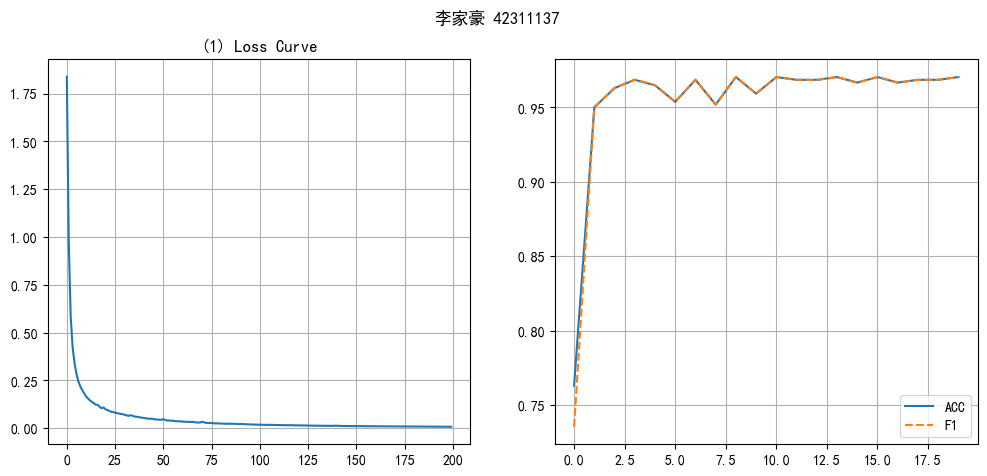


>>> 开始任务 2: Autoencoder


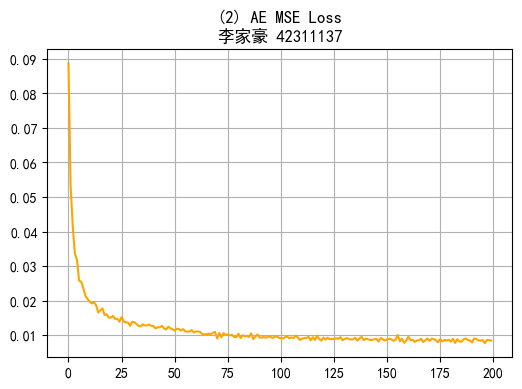


运行结束。


{'bp_losses': [1.838522616014544,
  0.9779506076510339,
  0.5852916598327841,
  0.42453561226152914,
  0.3394403124302392,
  0.2842106137839455,
  0.2438189972517253,
  0.21821007697250674,
  0.19843875681484507,
  0.18195049387396633,
  0.1656189605768757,
  0.15508886014131076,
  0.14491690246559527,
  0.13702243257208657,
  0.13118147762384183,
  0.12245289823479796,
  0.12221154152032085,
  0.11118509591488823,
  0.1043223659085117,
  0.10802399846168384,
  0.09891158506628935,
  0.09493902704831299,
  0.09070434330953343,
  0.08492551793303799,
  0.08480719732421865,
  0.08097294756779123,
  0.07866984687119635,
  0.07670887325989682,
  0.07434468900173334,
  0.07290426973679487,
  0.06979752147021526,
  0.06696573815935206,
  0.06449999979983742,
  0.06814422151478737,
  0.06481219526178084,
  0.06132440238175836,
  0.059183099465779265,
  0.05916497906721169,
  0.056009786736180636,
  0.05489622556250058,
  0.05340508970277289,
  0.05123510229442069,
  0.049879044516009385,
  0.

In [ ]:
# 使用上一个单元格准备好的数据进行训练

def run_tasks(
    X_train,
    X_test,
    y_train,
    y_test,
    num_classes,
    input_dim,
    epochs=200,
    lr=0.1,
    batch_size=32,
    lr_ae=0.5,
    batch_size_ae=64,
):
    y_test_oh = to_one_hot(y_test, num_classes)

    # 任务 (1): BP 网络分类
 
    print("\n>>> 开始任务 1: BP 神经网络分类")

    bp_layers = [
        LinearLayer(input_dim, 64),
        ReLU(),
        LinearLayer(64, num_classes),
    ]

    criterion = CrossEntropyWithSoftmax()
    losses = []
    acc_history = []
    f1_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0

        for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
            y_batch_oh = to_one_hot(y_batch, num_classes)

            out = X_batch
            for layer in bp_layers:
                out = layer.forward(out)

            loss = criterion.forward(out, y_batch_oh)
            epoch_loss += loss
            num_batches += 1

            d_out = criterion.backward()
            for layer in reversed(bp_layers):
                d_out = layer.backward(d_out)

            step_gradient_sgd(bp_layers, lr)

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        if epoch % 10 == 0:
            test_out = X_test
            for layer in bp_layers:
                test_out = layer.forward(test_out)

            _ = criterion.forward(test_out, y_test_oh)
            test_probs = criterion.probs

            acc, f1 = calculate_metrics(test_probs, y_test)
            acc_history.append(acc)
            f1_history.append(f1)
            print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Test ACC: {acc:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title("(1) Loss Curve")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(acc_history, label="ACC")
    plt.plot(f1_history, label="F1", linestyle="--")
    plt.legend()
    plt.grid(True)
    plt.suptitle("李家豪 42311137", y=0.98)
    plt.show()

    # ==========================================
    # 任务 (2): Autoencoder
    # ==========================================
    print("\n>>> 开始任务 2: Autoencoder")

    ae_layers = [
        LinearLayer(input_dim, 32),
        ReLU(),
        LinearLayer(32, input_dim),
        Sigmoid(),
    ]

    ae_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0

        for X_batch, _ in get_batches(X_train, y_train, batch_size_ae):
            out = X_batch
            for layer in ae_layers:
                out = layer.forward(out)

            loss = mse_loss(out, X_batch)
            epoch_loss += loss
            num_batches += 1

            d_out = 2 * (out - X_batch) / X_batch.shape[0]
            for layer in reversed(ae_layers):
                d_out = layer.backward(d_out)

            step_gradient_sgd(ae_layers, lr_ae)

        ae_losses.append(epoch_loss / num_batches)

    plt.figure(figsize=(6, 4))
    plt.plot(ae_losses, color="orange")
    plt.title("(2) AE MSE Loss\n李家豪 42311137")
    plt.grid(True)
    plt.show()

    print("\n运行结束。")

    return {
        "bp_losses": losses,
        "bp_acc": acc_history,
        "bp_f1": f1_history,
        "ae_losses": ae_losses,
    }


# 需要训练时取消下一行注释：
run_tasks(X_train, X_test, y_train, y_test, num_classes, input_dim)

